# Using digital elevation model differencing to estimate micro-topographical changes to a road
## Working with project data

### Objective
Difference digital elevation models from two sites at different slices in time to observe the development of wheel ruts and other micro-topographical features

### Datasets
The datasets used here are from unmanned aerial vehicle (UAV) surveys carried out from 11/09/2020 to 06/01/2022 on two 80-meter segments of gravel forest road in western Washington state. These datasets were collected at least every four months, if not more frequently.
___
First, we'll do some basic setup.

In [220]:
# Import packages
from osgeo import gdal 
import numpy as np
import rasterio as rio
from rasterio import plot, mask

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import xarray as xr
from IPython.display import HTML
import rioxarray as rioxarray
import geopandas as gpd
import astropy as ap

# Set parameter for animation
plt.rcParams["animation.html"] = "html5"

# Import pretty print
from pprint import pprint

In [2]:
# Show plots in the notebook
%matplotlib inline

In [3]:
# Define datasets
MEL14_20220428 = '../MEL14_data/20220428_clipped3.tif'
MEL14_20220309 = '../MEL14_data/20220309_clipped2.tif'

In [190]:
MEL14_20220428 = '../MEL14_data/20220428_wittkopf5_MEL14_dsm.tif'
MEL14_20220309 = '../MEL14_data/20220309_wittkopf3_MEL14_dsm.tif'

reproj_0428 = '../MEL14_data/20220428_reproj_test.tif'
reproj_0309 = '../MEL14_data/20220309_reproj_test.tif'

In [186]:
# !gdalinfo $MEL14_20220428

In [187]:
# !gdalinfo $MEL14_20220309

In [174]:
# !gdalwarp -of GTiff -s_srs EPSG:32610 -t_srs EPSG:32610 -cutline $mask_path -crop_to_cutline\
#         -tr 0.01 0.01 -r med -overwrite -multi \
#         $MEL14_20220428 $reproj_0428

In [175]:
# !gdalwarp -of GTiff -s_srs EPSG:32610 -t_srs EPSG:32610 -cutline $mask_path -crop_to_cutline\
#         -tr 0.01 0.01 -r med -overwrite -multi \
#         $MEL14_20220309 $reproj_0309

In [188]:
# !gdalinfo $reproj_0309

In [193]:
!gdaladdo -r gauss $MEL14_20220309

0...10...20...30...40...50...60...70...80...90...100 - done.


In [199]:
!gdalinfo $MEL14_20220309

Driver: GTiff/GeoTIFF
Files: ../MEL14_data/20220309_wittkopf3_MEL14_dsm.tif
Size is 2039, 9841
Coordinate System is:
ENGCRS["Arbitrary (m)",
    EDATUM[""],
    CS[Cartesian,2],
        AXIS["(E)",east,
            ORDER[1],
            LENGTHUNIT["metre",1,
                ID["EPSG",9001]]],
        AXIS["(N)",north,
            ORDER[2],
            LENGTHUNIT["metre",1,
                ID["EPSG",9001]]]]
Data axis to CRS axis mapping: 1,2
Origin = (4984.322650000000067,5083.164880000000267)
Pixel Size = (0.009460000000000,-0.009460000000000)
Metadata:
  AREA_OR_POINT=Area
  TIFFTAG_SOFTWARE=pix4dmapper
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
  PREDICTOR=3
Corner Coordinates:
Upper Left  (    4984.323,    5083.165) 
Lower Left  (    4984.323,    4990.069) 
Upper Right (    5003.612,    5083.165) 
Lower Right (    5003.612,    4990.069) 
Center      (    4993.967,    5036.617) 
Band 1 Block=2039x1 Type=Float32, ColorInterp=Gray
  NoData Value=-1e+04
  Overviews: 

In [307]:
#da_ov5_2 = rioxarray.open_rasterio(MEL14_20220428, overview_level = 5, mask_and_scale = True).squeeze()
#da_ov5_1 = rioxarray.open_rasterio(MEL14_20220309, overview_level = 5, mask_and_scale = True).squeeze()

da_ov2_2 = rioxarray.open_rasterio(MEL14_20220428, overview_level = 2, mask_and_scale = True).squeeze()
da_ov2_1 = rioxarray.open_rasterio(MEL14_20220309, overview_level = 2, mask_and_scale = True).squeeze()

da_full_2 = rioxarray.open_rasterio(MEL14_20220428, mask_and_scale = True).squeeze()
da_full_1 = rioxarray.open_rasterio(MEL14_20220309, mask_and_scale = True).squeeze()
#da_ov3_2 = rioxarray.open_rasterio(MEL14_20220428, overview_level = 3, mask_and_scale = True).squeeze()
#da_ov3_1 = rioxarray.open_rasterio(MEL14_20220309, overview_level = 3, mask_and_scale = True).squeeze()

In [160]:
mask_path = '../MEL14_data/clip_shape.shp'

In [6]:
mask_gdf = gpd.read_file(mask_path)
mask_gdf

,id,name,geometry
0,1,mask,"POLYGON ((4989.513 5079.540, 4995.729 5079.573..."


In [294]:
color = 'PiYG'
#color = 'RdBu'

In [293]:


#Compiled from pygeotools (dshean) and himat2cryo repositories

def checkma(a, fix=False):
    #isinstance(a, np.ma.MaskedArray)
    if np.ma.is_masked(a):
        out=a
    else:
        out=np.ma.array(a)
    #added to original code:
    return out

def maskfill(a, iterations=1, erode=False):
    import scipy.ndimage as ndimage 
    a = checkma(a)
    if erode:
        a = mask_islands(a, iterations)
    bmask = (~np.ma.getmaskarray(a))
    bmask_filled = ndimage.morphology.binary_fill_holes(bmask)
    #This will create valid values with a.filled in the original ma
    #a_erode.mask[:] = ~bmask_filled
    #return a_erode
    return ~bmask_filled

def gauss_fltr_astropy_fft(dem, size=None, sigma=None, origmask=False, fill_interior=False):
    
    """
    ***From pygeotools, commit to mainstream repo after full testing***
    # I use this over the direct Gaussian astropy filter  as it is way faster for large kernels
    Astropy gaussian filter properly handles convolution with NaN
    http://stackoverflow.com/questions/23832852/by-which-measures-should-i-set-the-size-of-my-gaussian-filter-in-matlab
    width1 = 3; sigma1 = (width1-1) / 6;
    Specify width for smallest feature of interest and determine sigma appropriately
    sigma is width of 1 std in pixels (not multiplier)
    scipy and astropy both use cutoff of 4*sigma on either side of kernel - 99.994%
    3*sigma on either side of kernel - 99.7%
    If sigma is specified, filter width will be a multiple of 8 times sigma 
    Alternatively, specify filter size, then compute sigma: sigma = (size - 1) / 8.
    If size is < the required width for 6-8 sigma, need to use different mode to create kernel
    mode 'oversample' and 'center' are essentially identical for sigma 1, but very different for sigma 0.3
    The sigma/size calculations below should work for non-integer sigma
    """

    #import astropy.nddata
    import astropy.convolution
    dem = checkma(dem)
    #Generate 2D gaussian kernel for input sigma and size
    #Default size is 8*sigma in x and y directions
    #kernel = astropy.nddata.make_kernel([size, size], sigma, 'gaussian')
    #Size must be odd
    if size is not None:
        size = int(np.floor(size/2)*2 + 1)
        size = max(size, 3)
    #Truncate the filter at this many standard deviations. Default is 4.0
    truncate = 3.0
    if size is not None and sigma is None:
        sigma = (size - 1) / (2*truncate)
    elif size is None and sigma is not None:
        #Round up to nearest odd int
        size = int(np.ceil((sigma * (2*truncate) + 1)/2)*2 - 1)
    elif size is None and sigma is None:
        #Use default parameters
        sigma = 1
        size = int(np.ceil((sigma * (2*truncate) + 1)/2)*2 - 1)
    size = max(size, 3)
    kernel = astropy.convolution.Gaussian2DKernel(sigma, x_size=size, y_size=size, mode='oversample')

    print("Applying gaussian smoothing filter with size %i and sigma %0.3f (sum %0.3f)" % \
            (size, sigma, kernel.array.sum()))

    #This will fill holes
    #np.nan is float
    #dem_filt_gauss = astropy.nddata.convolve(dem.astype(float).filled(np.nan), kernel, boundary='fill', fill_value=np.nan)
    #dem_filt_gauss = astropy.convolution.convolve(dem.astype(float).filled(np.nan), kernel, boundary='fill', fill_value=np.nan)
    #Added normalization to ensure filtered values are not brightened/darkened if kernelsum != 1
    dem_filt_gauss = astropy.convolution.convolve_fft(dem.astype(float).filled(np.nan), kernel, boundary='fill', 
                                                      fill_value=np.nan, normalize_kernel=True,
                                                     allow_huge=True)
    #This will preserve original ndv pixels, applying original mask after filtering
    if origmask:
        print("Applying original mask")
        #Allow filling of interior holes, but use original outer edge
        if fill_interior:
            mask = maskfill(dem)
        else:
            mask = dem.mask
        dem_filt_gauss = np.ma.array(dem_filt_gauss, mask=mask, fill_value=dem.fill_value)
    out = np.ma.fix_invalid(dem_filt_gauss, copy=False, fill_value=dem.fill_value)
    out.set_fill_value(dem.fill_value.astype(dem.dtype))
    return out.astype(dem.dtype), size

## Overview 2:

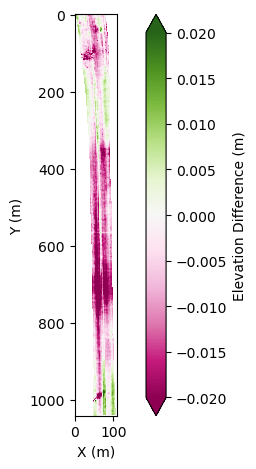

In [438]:
#clipping using rioxarray
da1_clipped = da_ov2_1.rio.clip(mask_gdf.geometry)
da2_clipped = da_ov2_2.rio.clip(mask_gdf.geometry)

#reprojecting and matching
da2_clipped_proj = da2_clipped.rio.reproject_match(da1_clipped, resampling = 3)
da_extent = da2_clipped_proj.rio.bounds()
#difference and plotting
diff = da2_clipped_proj-da1_clipped

f, ax = plt.subplots()
plt.imshow(diff, cmap = color, vmin= -0.02, vmax=0.02)
plt.colorbar(label='Elevation Difference (m)', extend='both')

#ax.text(0.175, 0.08, 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
#ax.text(0.175, 0.3, 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

plt.tight_layout()
#plt.savefig('Difference_MEL_overview=2.png', bbox_inches='tight', dpi=300)
#plt.show()

In [441]:
diff_hp

<xarray.DataArray (y: 1042, x: 109)>
array([[-0.00053752,  0.00349947,  0.00748034, ...,         nan,
                nan,         nan],
       [-0.00158748,  0.00421706,  0.0095077 , ...,         nan,
                nan,         nan],
       [-0.00525696,  0.00255937,  0.00915988, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ..., -0.00410644,
        -0.00296091,         nan],
       [        nan,         nan,         nan, ...,  0.00071119,
         0.00115562,  0.00359205],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * x            (x) float64 4.99e+03 4.99e+03 4.99e+03 ... 4.998e+03 4.998e+03
  * y            (y) float64 5.079e+03 5.079e+03 ... 5.001e+03 5.001e+03
    band         int32 1
    spatial_ref  int32 0

In [439]:
#This controls width of gaussian kernel standard deviation in pixels
#Play around with a few values
sigma = 10

diff_ma_smooth, size = gauss_fltr_astropy_fft(diff, sigma = sigma)

Applying gaussian smoothing filter with size 61 and sigma 10.000 (sum 0.995)


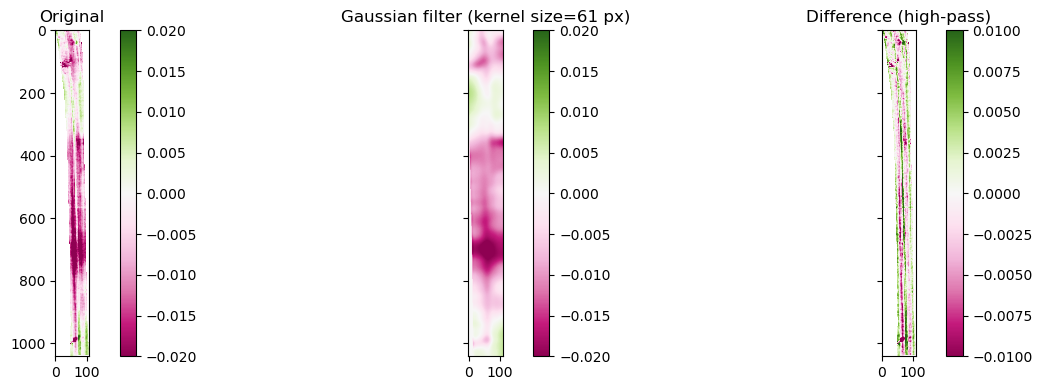

In [440]:
f, axa = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,4))
m = axa[0].imshow(diff, cmap = color , vmin = -0.02, vmax = 0.02)
f.colorbar(m, ax=axa[0])
axa[0].set_title("Original")
m = axa[1].imshow(diff_ma_smooth, cmap = color, vmin = -0.02, vmax = 0.02)
f.colorbar(m, ax=axa[1])
axa[1].set_title("Gaussian filter (kernel size=%s px)" % size)
diff_hp = diff - diff_ma_smooth
m = axa[2].imshow(diff_hp , cmap=color, vmin=-0.01, vmax=0.01)
f.colorbar(m, ax=axa[2])
axa[2].set_title("Difference (high-pass)")
#plt.savefig('high-pass filter attempt 2, on diff.png', bbox_inches='tight', dpi=300)
plt.tight_layout()

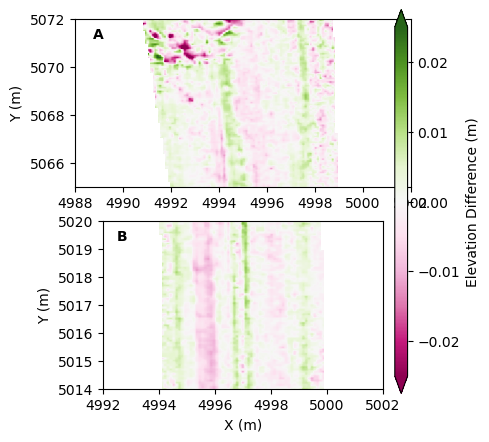

In [361]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1)

im = ax1.imshow(diff_hp, cmap = color, vmin= -0.025, vmax=0.025, extent=da_extent)
ax1.set_xlim(4988,5002)
ax1.set_ylim(5065,5072)
ax1.set_ylabel('Y (m)')

ax2.imshow(diff_hp, cmap = color, vmin= -0.025, vmax=0.025, extent=da_extent)
ax2.set_xlim(4992,5002)
ax2.set_ylim(5014,5020)

ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')


cb_ax = fig.add_axes([0.75, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax, label='Elevation Difference (m)', extend='both')

ax1.text(0.07, 0.95, 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax1.transAxes)
ax2.text(0.07, 0.95, 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax2.transAxes)

#fig.colorbar(ax=ax1,label='Elevation Difference (m)', extend='both')
#plt.tight_layout()
#plt.savefig('Difference_zoom.png', bbox_inches='tight', dpi=300)
plt.show()

## Full Res:

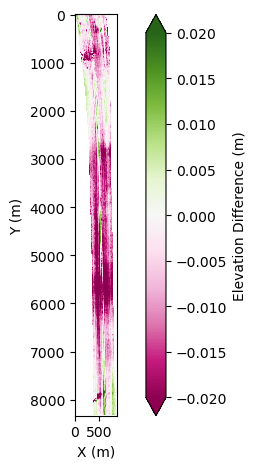

In [426]:
#clipping using rioxarray
da1_clipped = da_full_1.rio.clip(mask_gdf.geometry)
da2_clipped = da_full_2.rio.clip(mask_gdf.geometry)

#reprojecting and matching
da2_clipped_proj = da2_clipped.rio.reproject_match(da1_clipped, resampling = 3)
da_extent = da2_clipped_proj.rio.bounds()
#difference and plotting
diff = da2_clipped_proj-da1_clipped

f, ax = plt.subplots()
plt.imshow(diff, cmap = color, vmin= -0.02, vmax=0.02)
plt.colorbar(label='Elevation Difference (m)', extend='both')

#ax.text(0.175, 0.08, 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
#ax.text(0.175, 0.3, 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

plt.tight_layout()
#plt.savefig('Difference_MEL_overview=2.png', bbox_inches='tight', dpi=300)
#plt.show()

In [434]:

#This controls width of gaussian kernel standard deviation in pixels
#Play around with a few values
sigma = 50

diff_ma_smooth, size = gauss_fltr_astropy_fft(diff, sigma = sigma)

Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 0.995)


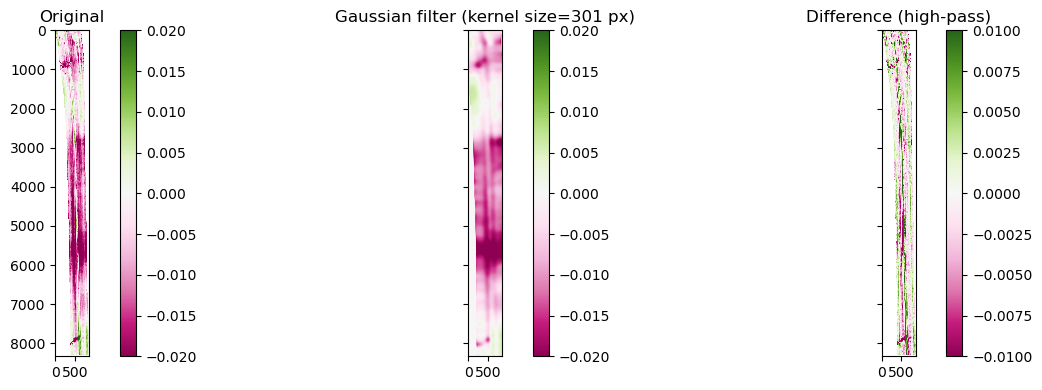

In [435]:
f, axa = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,4))
m = axa[0].imshow(diff, cmap = color , vmin = -0.02, vmax = 0.02)
f.colorbar(m, ax=axa[0])
axa[0].set_title("Original")
m = axa[1].imshow(diff_ma_smooth, cmap = color, vmin = -0.02, vmax = 0.02)
f.colorbar(m, ax=axa[1])
axa[1].set_title("Gaussian filter (kernel size=%s px)" % size)
diff_hp = diff - diff_ma_smooth
m = axa[2].imshow(diff_hp , cmap=color, vmin=-0.01, vmax=0.01)
f.colorbar(m, ax=axa[2])
axa[2].set_title("Difference (high-pass)")
#plt.savefig('high-pass filter attempt 2, on diff.png', bbox_inches='tight', dpi=300)
plt.tight_layout()

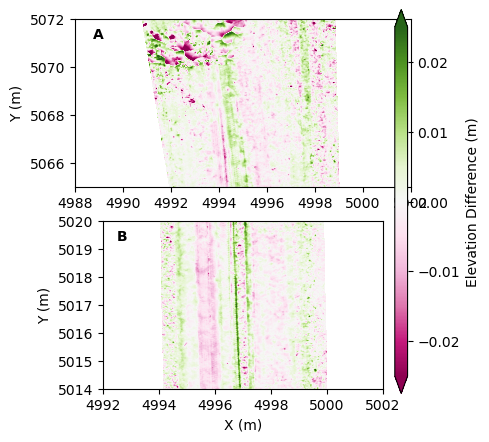

In [436]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1)

im = ax1.imshow(diff_hp, cmap = color, vmin= -0.025, vmax=0.025, extent=da_extent)
ax1.set_xlim(4988,5002)
ax1.set_ylim(5065,5072)
ax1.set_ylabel('Y (m)')

ax2.imshow(diff_hp, cmap = color, vmin= -0.025, vmax=0.025, extent=da_extent)
ax2.set_xlim(4992,5002)
ax2.set_ylim(5014,5020)

ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')


cb_ax = fig.add_axes([0.75, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax, label='Elevation Difference (m)', extend='both')

ax1.text(0.07, 0.95, 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax1.transAxes)
ax2.text(0.07, 0.95, 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax2.transAxes)

#fig.colorbar(ax=ax1,label='Elevation Difference (m)', extend='both')
#plt.tight_layout()
#plt.savefig('Difference_zoom.png', bbox_inches='tight', dpi=300)
plt.show()

In [68]:
#loading orthomosaiac
fn_ortho_MEL_20220428 = '../MEL14_data/20220428_wittkopf5_MEL14_rgb_orthomosaic.tif'
ortho_ov2_MEL_20220428 = rioxarray.open_rasterio(fn_ortho_MEL_20220428, overview_level = 2)
ortho_MEL_20220428 = rio.open(fn_ortho_MEL_20220428).read()
#transposing location of color band information so that imshow likes it
ortho_MEL_20220428 = np.transpose(ortho_MEL_20220428, (1,2,0))

##I can't figure out how to load the overview with rioxarray and pass it to imshow in a way that it likes so I'm going to move on to the longitudinal
##profile
ortho_ov2_MEL_20220428 = ortho_ov2_MEL_20220428.transpose('y','x','band')
#ortho_ov3_MEL_20220428 = np.transpose(ortho_ov3_MEL_20220428, ortho_ov3_MEL_20220428.band)
ortho_ov2_MEL_20220428 = ortho_ov2_MEL_20220428.rio.clip(mask_gdf.geometry)

In [82]:
#!gdalinfo $fn_ortho_MEL_20220428

In [81]:
#!gdaladdo -r gauss $fn_ortho_MEL_20220428

In [8]:
#making dem hillshade
hs_fn1 = 'test1_hs.tif'
hs_fn2 = 'test2_hs.tif'

In [17]:
#!gdaldem hillshade $MEL14_20220309 $hs_fn1
#!gdaldem hillshade $MEL14_20220428 $hs_fn2

In [9]:
hs_src1 = rio.open(hs_fn1)
hs1 = hs_src1.read(1, masked=True)
hs_extent1 = rio.plot.plotting_extent(hs_src1)
hs_extent1

(4988.352651642962, 4998.664030259932, 5000.626364536125, 5083.969000345493)

In [10]:
hs_src2 = rio.open(hs_fn2)
hs2 = hs_src2.read(1, masked=True)
hs_extent2 = rio.plot.plotting_extent(hs_src2)
hs_extent2

(4988.349090922401, 4998.668511810639, 5000.624305911869, 5083.967099863151)

## Working 4 panel plot, no zoom

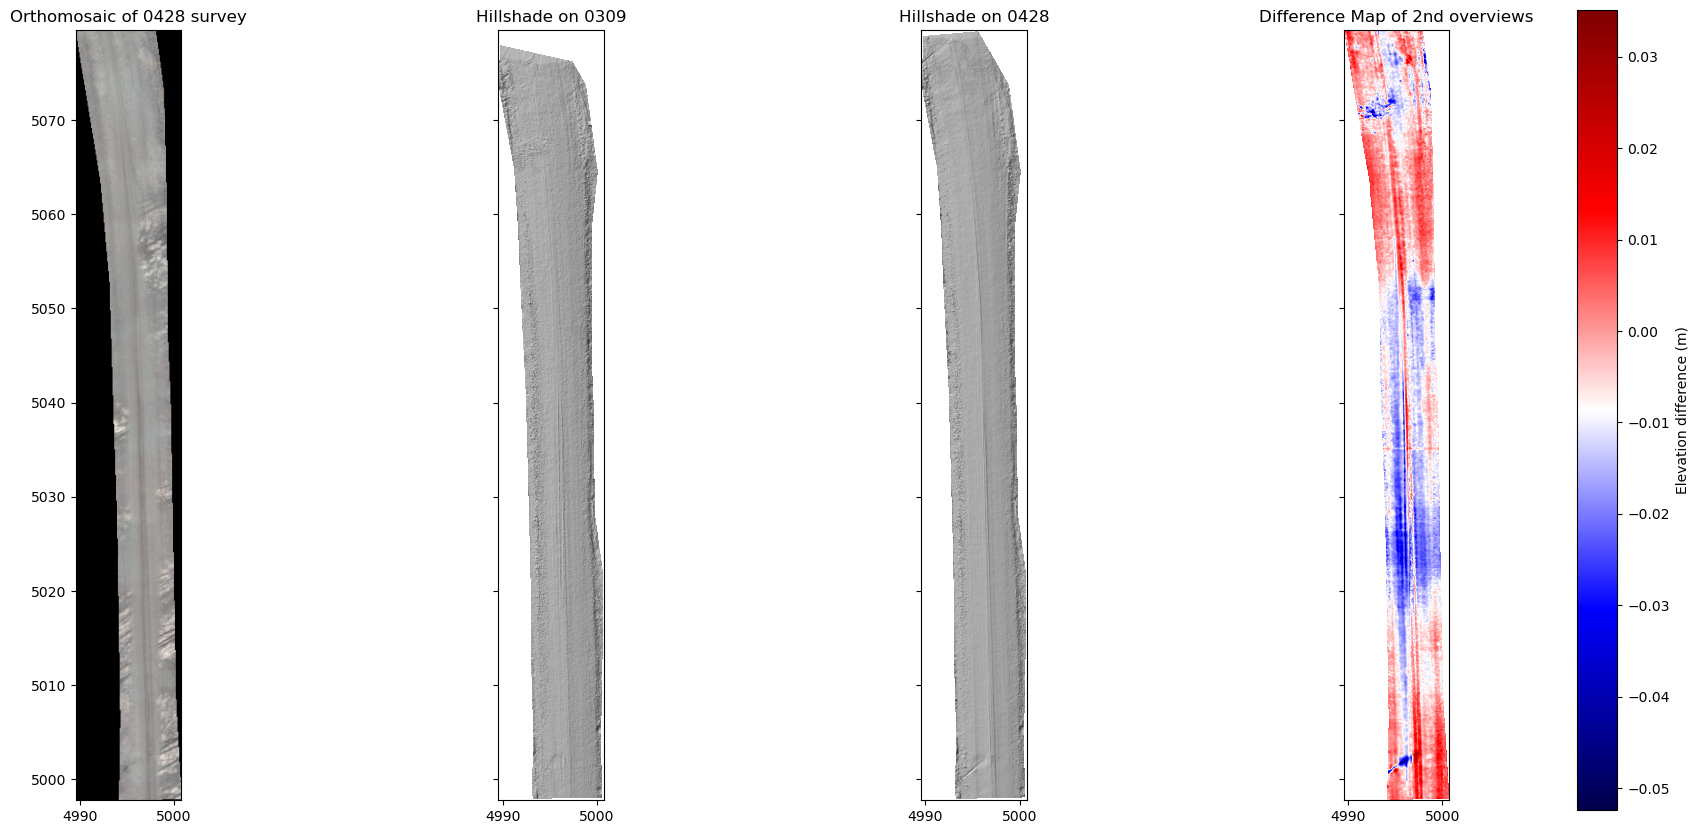

In [281]:
fig, axs = plt.subplots(nrows=1, ncols=4, sharex = True, sharey = True, figsize=(20, 10))
fig.subplots_adjust(wspace=0.5)

# Plot da2_clipped orthomosaic
im1 = axs[0].imshow(ortho_ov2_MEL_20220428, extent = da_extent)
axs[0].set_title('Orthomosaic of 0428 survey')

# Plot hillshade of da1_clipped
im2 = axs[1].imshow(hs1, cmap='gray', extent = da_extent)
axs[1].set_title('Hillshade on 0309')

# Plot hillshade of da2_clipped
im3 = axs[2].imshow(hs2, cmap='gray', extent = da_extent)
axs[2].set_title('Hillshade on 0428')

# Plot difference map with the defined colormap
im4 = axs[3].imshow(diff, cmap='seismic', extent= da_extent)
axs[3].set_title('Difference Map of 2nd overviews')

# Add colorbars for the difference plot
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im4, cax=cbar_ax, label='Elevation difference (m)')

plt.show()

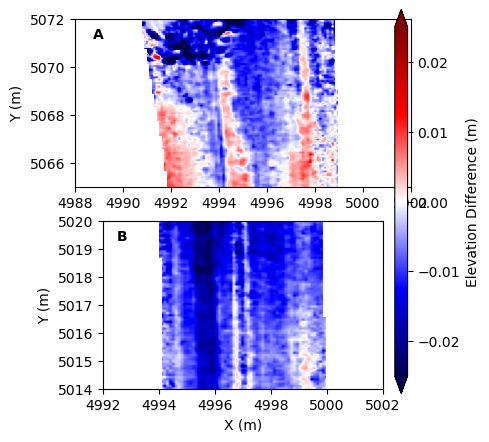

In [156]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1)

im = ax1.imshow(diff, cmap = 'seismic', vmin= -0.025, vmax=0.025, extent=da_extent)
ax1.set_xlim(4988,5002)
ax1.set_ylim(5065,5072)
ax1.set_ylabel('Y (m)')

ax2.imshow(diff, cmap = 'seismic', vmin= -0.025, vmax=0.025, extent=da_extent)
ax2.set_xlim(4992,5002)
ax2.set_ylim(5014,5020)

ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')


cb_ax = fig.add_axes([0.75, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax, label='Elevation Difference (m)', extend='both')

ax1.text(0.07, 0.95, 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax1.transAxes)
ax2.text(0.07, 0.95, 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax2.transAxes)

#fig.colorbar(ax=ax1,label='Elevation Difference (m)', extend='both')
#plt.tight_layout()
#plt.savefig('Difference_zoom.png', bbox_inches='tight', dpi=300)
plt.show()

## Working 4-panel plot, all different axes

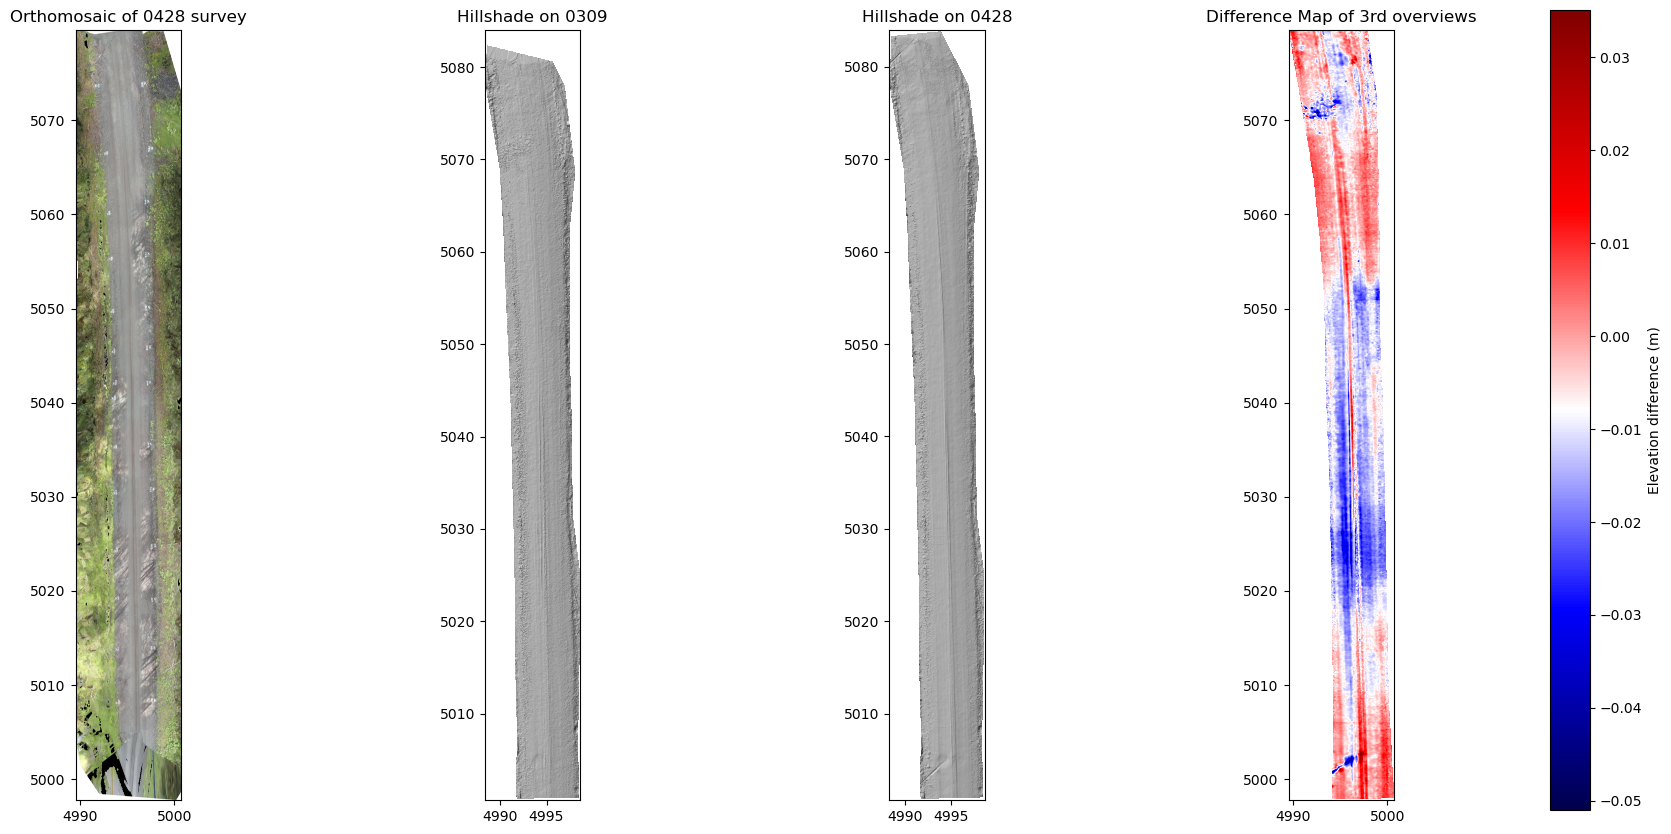

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))
fig.subplots_adjust(wspace=0.2)

# Plot da2_clipped orthomosaic
im1 = axs[0].imshow(ortho_MEL_20220428, extent = da_extent)
axs[0].set_title('Orthomosaic of 0428 survey')

# Plot hillshade of da1_clipped
im2 = axs[1].imshow(hs1, cmap='gray', extent = hs_extent1)
axs[1].set_title('Hillshade on 0309')

# Plot hillshade of da2_clipped
im3 = axs[2].imshow(hs2, cmap='gray', extent = hs_extent2)
axs[2].set_title('Hillshade on 0428')

# Plot difference map with the defined colormap
im4 = axs[3].imshow(diff, cmap='seismic', extent = da_extent)
axs[3].set_title('Difference Map of 3rd overviews')

# Add colorbars for the difference plot
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im4, cax=cbar_ax, label='Elevation difference (m)')

plt.show()

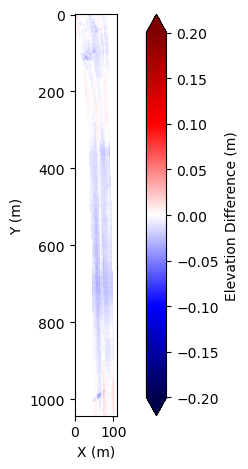

In [25]:
diff = da2_clipped_proj-da1_clipped

f, ax = plt.subplots()
plt.imshow(diff, cmap = 'seismic', vmin= -0.2, vmax=0.2)
plt.colorbar(label='Elevation Difference (m)', extend='both')

#ax.text(0.175, 0.08, 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
#ax.text(0.175, 0.3, 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

plt.tight_layout()
#plt.savefig('Difference_MEL.png', bbox_inches='tight', dpi=300)
plt.show()

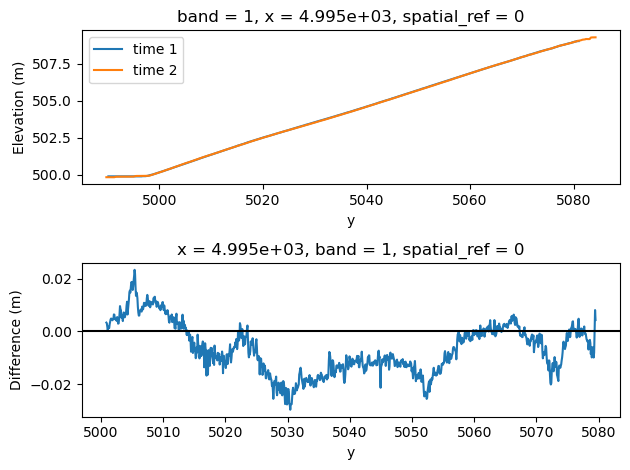

In [442]:
x = 4995

f, axa = plt.subplots(2, 1)
da_ov2_1.sel(x=x, method='nearest').plot(ax=axa[0], label='time 1')
da_ov2_2.sel(x=x, method='nearest').plot(ax=axa[0], label='time 2')
axa[0].legend()
axa[0].set_ylabel('Elevation (m)')
diff.sel(x=x, method='nearest').plot(ax=axa[1])
axa[1].axhline(0, color='k')
axa[1].set_ylabel('Difference (m)')
#plt.savefig('longitudinal plot, x=4995, ov = 2.png', bbox_inches='tight', dpi=300)
plt.tight_layout()

We can open the datasets using the [rasterio](https://rasterio.readthedocs.io/en/stable/) package:

In [17]:
KID13_nov = rio.open(KID13_20201109)
KID13_feb = rio.open(KID13_20210208)

Let's look at the profiles for these datasets.

In [18]:
pprint(KID13_nov.profile)
pprint(KID13_feb.profile)

{'count': 1,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 15351,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.006419992325402788, 0.0, 4987.076,
       0.0, -0.006419998697153266, 5104.8759),
 'width': 2606}
{'count': 1,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 15016,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.006339975399753869, 0.0, 4984.9834,
       0.0, -0.006339997336174742, 5103.2018),
 'width': 3252}


We can see that while the projections are the same, the resolutions and extents are not. To be able to difference the DEMs, we will need to ensure that they are the same projection, resolution, and extent.

We'll load the DEMs as arrays and plot them so we can see this graphically.

In [19]:
# Read in the DEMs
KID13_nov_np = KID13_nov.read(1)
KID13_feb_np = KID13_feb.read(1)

# Mask nodata values
KID13_nov_mask = np.ma.masked_values(KID13_nov_np, -10000.0)
KID13_feb_mask = np.ma.masked_values(KID13_feb_np, -10000.0)

In [20]:
# Define the figure and plot as animation for clarity
fig, ax = plt.subplots()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

im1 = plt.imshow(KID13_nov_mask)
im2 = plt.imshow(KID13_feb_mask)
ims = [[im1], [im2]]

plt.xlabel('Px', fontweight='bold')
plt.ylabel('Px', fontweight='bold')
plt.colorbar(label='Elevation (m)')
plt.title('KID 13 Nov - Feb', fontweight='bold')

anim = animation.ArtistAnimation(fig, ims, interval=2000, repeat_delay=1000)
plt.close()

anim

We can see that the datasets cannot be differenced as they are currently.

To ensure the same projection, resolution, and extent, we can use the [`gdalwarp`](https://www.gdal.org/gdalwarp.html) command line utility. Below you'll see that instead of defining a normal rectangular extent using (right, bottom, left, top), I'm clipping the datasets to pre-defined shapefiles.

**Note:** I'm using the single `gdalwarp` command line utility here because I have only four rasters. If I had, say, 100 rasters, I would be much better off creating a shell script or using a `gdal` Python API.

In [21]:
!gdalwarp -of GTiff -s_srs EPSG:32610 -t_srs EPSG:32610 -cutline ./KID13_data/Shapefiles/KID13_UTM.shp -crop_to_cutline\
        -tr 0.01 0.01 -r med -overwrite -multi \
        ./KID13_data/KID13_20201109_proj.tif ./KID13_data/KID13_nov_reproj.tif

Creating output file that is 1236P x 8311L.
Processing ./KID13_data/KID13_20201109_proj.tif [1/1] : 0Using internal nodata values (e.g. -10000) for image ./KID13_data/KID13_20201109_proj.tif.
Copying nodata values from source ./KID13_data/KID13_20201109_proj.tif to destination ./KID13_data/KID13_nov_reproj.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [22]:
!gdalwarp -of GTiff -s_srs EPSG:32610 -t_srs EPSG:32610 -cutline ./KID13_data/Shapefiles/KID13_UTM.shp -crop_to_cutline\
        -tr 0.01 0.01 -r med -overwrite -multi \
        ./KID13_data/KID13_20210208_proj.tif ./KID13_data/KID13_feb_reproj.tif

Creating output file that is 1236P x 8311L.
Processing ./KID13_data/KID13_20210208_proj.tif [1/1] : 0Using internal nodata values (e.g. -10000) for image ./KID13_data/KID13_20210208_proj.tif.
Copying nodata values from source ./KID13_data/KID13_20210208_proj.tif to destination ./KID13_data/KID13_feb_reproj.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


Now that we have DEMs that are the same projection, extent, and resolution, let's look at them.

In [23]:
# Read in each DEM for CUH, look at the profile, load the DEMs as arrays, and mask nodata values - CUH
KID13_nov_proj = rio.open('./KID13_data/KID13_nov_reproj.tif')
pprint(KID13_nov_proj.profile)
KID13_nov_proj_read = KID13_nov_proj.read(1)
KID13_nov_proj_mask = np.ma.masked_values(KID13_nov_proj_read, -10000.)
KID13_nov_proj.close()

KID13_feb_proj  = rio.open('./KID13_data/KID13_feb_reproj.tif')
pprint(KID13_feb_proj.profile)
KID13_feb_proj_read = KID13_feb_proj.read(1)
KID13_feb_proj_mask = np.ma.masked_values(KID13_feb_proj_read, -10000.)
KID13_feb_proj.close()

{'count': 1,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 8311,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.01, 0.0, 4988.834808077358,
       0.0, -0.01, 5097.191270051388),
 'width': 1236}
{'count': 1,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 8311,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.01, 0.0, 4988.834808077358,
       0.0, -0.01, 5097.191270051388),
 'width': 1236}


In [24]:
# Define plotting extent, then plot as animation for clarity - CUH
KID13_nov_extent = rio.plot.plotting_extent(KID13_nov_proj)
KID13_feb_extent = rio.plot.plotting_extent(KID13_feb_proj)

fig, ax = plt.subplots()
im1 = plt.imshow(KID13_nov_proj_mask, extent=KID13_nov_extent)
im2 = plt.imshow(KID13_feb_proj_mask, extent=KID13_feb_extent)

ax.set_xlabel('X (m)', fontweight='bold')
ax.set_ylabel('Y (m)', fontweight='bold')
plt.colorbar(label='Elevation (m)')
plt.title('KID13', fontweight='bold')

ims = [[im1], [im2]]


anim = animation.ArtistAnimation(fig, ims, interval=2000, repeat_delay=1000)
plt.close()

anim

Excellent! Our DEMs for each site now match. Let's difference them and plot the output:

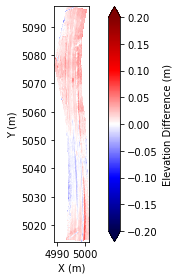

In [25]:
difference_KID13 = (KID13_feb_proj_mask-KID13_nov_proj_mask)

fig, ax = plt.subplots()
plt.imshow(difference_KID13, cmap = 'seismic', vmin= -0.2, vmax=0.2, extent=KID13_nov_extent)
plt.colorbar(label='Elevation Difference (m)', extend='both')

#ax.text(0.175, 0.08, 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
#ax.text(0.175, 0.3, 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
plt.tight_layout()
plt.savefig('Difference_KID.png', bbox_inches='tight', dpi=300)
plt.show()

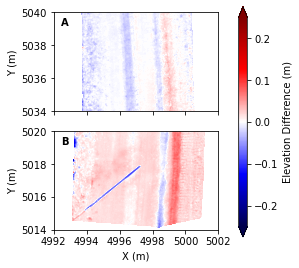

In [85]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

im = ax1.imshow(difference_KID13, cmap = 'seismic', vmin= -0.25, vmax=0.25, extent=KID13_nov_extent)
ax1.set_xlim(4992,5002)
ax1.set_ylim(5034,5040)
ax1.set_ylabel('Y (m)')

ax2.imshow(difference_KID13, cmap = 'seismic', vmin= -0.25, vmax=0.25, extent=KID13_nov_extent)
ax2.set_xlim(4992,5002)
ax2.set_ylim(5014,5020)

ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')


cb_ax = fig.add_axes([0.75, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax, label='Elevation Difference (m)', extend='both')

ax1.text(0.07, 0.95, 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax1.transAxes)
ax2.text(0.07, 0.95, 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax2.transAxes)

#fig.colorbar(ax=ax1,label='Elevation Difference (m)', extend='both')
#plt.tight_layout()
plt.savefig('Difference_zoom.png', bbox_inches='tight', dpi=300)
plt.show()

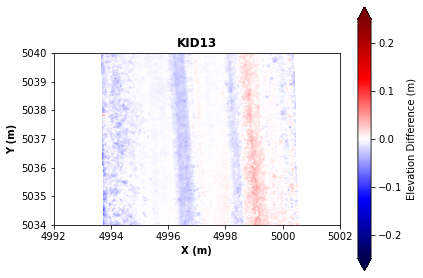

In [79]:
fig, ax = plt.subplots()
plt.imshow(difference_KID13, cmap = 'seismic', vmin= -0.25, vmax=0.25, extent=KID13_nov_extent)
plt.colorbar(label='Elevation Difference (m)', extend='both')

ax.set_xlim(4992,5002)
ax.set_ylim(5034,5040)
ax.set_xlabel('X (m)', fontweight='bold')
ax.set_ylabel('Y (m)', fontweight='bold')
plt.title('KID13', fontweight='bold')
plt.tight_layout()
plt.savefig('Difference_zoomMid.png', bbox_inches='tight', dpi=300)
plt.show()

In [3]:
# # Define datasets
# MEL14_20220309 = 'C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220309_clipped2.tif'
# MEL14_20220428 = 'C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220428_clipped3.tif'

We can open the datasets using the [rasterio](https://rasterio.readthedocs.io/en/stable/) package:

In [411]:
MEL14_0309 = rio.open(MEL14_20220309)
MEL14_0428 = rio.open(MEL14_20220428)

Let's look at the profiles for these datasets.

In [6]:
pprint(MEL14_0309.profile)
pprint(MEL14_0428.profile)

{'blockysize': 1,
 'count': 1,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 8810,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.009459980382541014, 0.0, 4988.352651642962,
       0.0, -0.009460004064627514, 5083.969000345493),
 'width': 1090}
{'blockysize': 1,
 'count': 1,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 9635,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.008649975597852305, 0.0, 4988.349090922401,
       0.0, -0.008650004561627622, 5083.967099863151),
 'width': 1193}


We can see that while the projections are the same, the resolutions and extents are not. To be able to difference the DEMs, we will need to ensure that they are the same projection, resolution, and extent.

We'll load the DEMs as arrays and plot them so we can see this graphically.

In [7]:
# Read in the DEMs
MEL14_0309_np = MEL14_0309.read(1)
MEL14_0428_np = MEL14_0428.read(1)

# Mask nodata values
MEL14_0309_mask = np.ma.masked_values(MEL14_0309_np, -10000.0)
MEL14_0428_mask = np.ma.masked_values(MEL14_0428_np, -10000.0)

In [8]:
# Define the figure and plot as animation for clarity
fig1, ax1 = plt.subplots()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top') 

im1 = plt.imshow(MEL14_0309_mask)
im2 = plt.imshow(MEL14_0428_mask)
ims = [[im1], [im2]]

plt.xlabel('Px', fontweight='bold')
plt.ylabel('Px', fontweight='bold')
plt.colorbar(label='Elevation (m)')
plt.title('MEL-14 20220309-20220428', fontweight='bold')

anim1 = animation.ArtistAnimation(fig1, ims, interval=2000, repeat_delay=1000)
plt.close()

anim1

RuntimeError: Requested MovieWriter (ffmpeg) not available

We can see that the datasets cannot be differenced as they are currently.

To ensure the same projection, resolution, and extent, we can use the [`gdalwarp`](https://www.gdal.org/gdalwarp.html) command line utility. Below you'll see that instead of defining a normal rectangular extent using (right, bottom, left, top), I'm clipping the datasets to pre-defined shapefiles.

**Note:** I'm using the single `gdalwarp` command line utility here because I have only four rasters. If I had, say, 100 rasters, I would be much better off creating a shell script or using a `gdal` Python API.

In [8]:
!gdalwarp -of GTiff -s_srs EPSG:32610 -t_srs EPSG:32610 -cutline C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/MEL14_UTM.shp -crop_to_cutline\
        -tr 0.01 0.01 -r med -overwrite -multi \
        C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220309_clipped2.tif C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/MEL14_20220309_reproj.tif

Creating output file that is 1032P x 8335L.
Processing C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220309_clipped2.tif [1/1] : 0Using internal nodata values (e.g. -10000) for image C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220309_clipped2.tif.
Copying nodata values from source C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220309_clipped2.tif to destination C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/MEL14_20220309_reproj.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [9]:
!gdalwarp -of GTiff -s_srs EPSG:32610 -t_srs EPSG:32610 -cutline C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/MEL14_UTM.shp -crop_to_cutline\
        -tr 0.01 0.01 -r med -overwrite -multi \
        C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220428_clipped3.tif C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/MEL14_20220428_reproj.tif

Creating output file that is 1032P x 8335L.
Processing C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220428_clipped3.tif [1/1] : 0Using internal nodata values (e.g. -10000) for image C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220428_clipped3.tif.
Copying nodata values from source C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220428_clipped3.tif to destination C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/MEL14_20220428_reproj.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


Now that we have DEMs that are the same projection, extent, and resolution, let's look at them.

In [10]:
# Read in each DEM for CUH, look at the profile, load the DEMs as arrays, and mask nodata values - CUH
MEL14_20220309_reproj = rio.open('C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/MEL14_20220309_reproj.tif')
pprint(MEL14_20220309_reproj.profile)
MEL14_20220309_reproj_read = MEL14_20220309_reproj.read(1)
MEL14_20220309_reproj_mask = np.ma.masked_values(MEL14_20220309_reproj_read, -10000.)
MEL14_20220309_reproj.close()

MEL14_20220428_reproj  = rio.open('C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/MEL14_20220428_reproj.tif')
pprint(MEL14_20220428_reproj.profile)
MEL14_20220428_reproj_read = MEL14_20220428_reproj.read(1)
MEL14_20220428_reproj_mask = np.ma.masked_values(MEL14_20220428_reproj_read, -10000.)
MEL14_20220428_reproj.close()


{'count': 1,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 8335,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.01, 0.0, 4988.348838527598,
       0.0, -0.01, 5083.972941589739),
 'width': 1032}
{'count': 1,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 8335,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.01, 0.0, 4988.348838527598,
       0.0, -0.01, 5083.972941589739),
 'width': 1032}


In [11]:
# Define plotting extent, then plot as animation for clarity - CUH
MEL14_20220309_reproj_extent = rio.plot.plotting_extent(MEL14_20220309_reproj)
MEL14_20220428_reproj_extent = rio.plot.plotting_extent(MEL14_20220428_reproj)

fig, ax = plt.subplots()
im1 = plt.imshow(MEL14_20220309_reproj_mask, extent=MEL14_20220309_reproj_extent)
im2 = plt.imshow(MEL14_20220428_reproj_mask, extent=MEL14_20220428_reproj_extent)

ax.set_xlabel('X (m)', fontweight='bold')
ax.set_ylabel('Y (m)', fontweight='bold')
plt.colorbar(label='Elevation (m)')
plt.title('MEL14', fontweight='bold')

ims = [[im1], [im2]]


anim = animation.ArtistAnimation(fig, ims, interval=2000, repeat_delay=1000)
plt.close()

anim

RuntimeError: Requested MovieWriter (ffmpeg) not available

Excellent! Our DEMs for each site now match. Let's difference them and plot the output:

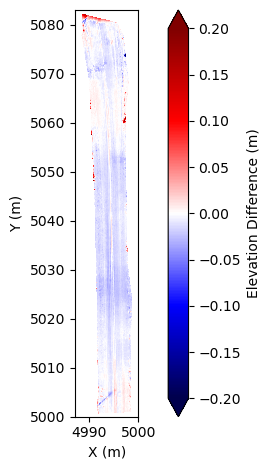

In [12]:
difference_MEL14 = (MEL14_20220428_reproj_mask-MEL14_20220309_reproj_mask)

fig, ax = plt.subplots()
plt.imshow(difference_MEL14, cmap = 'seismic', vmin= -0.2, vmax=0.2, extent=MEL14_20220428_reproj_extent)
plt.colorbar(label='Elevation Difference (m)', extend='both')

#ax.text(0.175, 0.08, 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
#ax.text(0.175, 0.3, 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_xlim(4987, 5000)
ax.set_ylim(5000, 5083)
plt.tight_layout()
plt.savefig('Difference_MEL.png', bbox_inches='tight', dpi=300)
plt.show()